## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#loading the dataset to the dataframe
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
#number of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
#unique users
df.nunique()['user_id']

290584

d. The proportion of users converted.

In [5]:
# count of converted users
converted_count = len(df.query("converted == '1'")['user_id'])
#total users
total_count = df.shape[0]
#calculation of proportion
converted_proportion = converted_count*100/total_count
print("The proportion of converted users is: {}".format(converted_proportion))

The proportion of converted users is: 11.965919355605513


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
#count of when treatment user lands in old_page
fault1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print("Number of time the treatement user lands in the old page: {}".format(len(fault1)))

#count of when control user lands in new_page
fault2 = df.query("group == 'control' and landing_page == 'new_page'")
print("Number of time the control user lands in the new page: {}".format(len(fault2)))

#count of total mismatch is the sum of the above 2 cases
mismatch_count = len(fault1) + len(fault2)
print("Misamtch count of new_page and treatment: {}".format(mismatch_count))

Number of time the treatement user lands in the old page: 1965
Number of time the control user lands in the new page: 1928
Misamtch count of new_page and treatment: 3893


f. Do any of the rows have missing values?

In [7]:
#to see the count of values in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


From the above details of the dataset, there are no missing values.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# drop rows for faulty treatment groups
df2 = df.drop(df.query("group == 'treatment' and landing_page == 'old_page'").index)
# drop rows for faulty control groups
df2.drop(df.query("group == 'control' and landing_page == 'new_page'").index, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
#count of unique values
df2.nunique()['user_id']

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
#number of duplicated values
sum(df2['user_id'].duplicated())

1

In [12]:
#identify the duplicates
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
#have alookk at the rows that are duplicated
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


We can notice from the rows that timestamp is the only element that separates the 2 duplicated. Hence we delete the row with the second timstamp, i.e., '2017-01-14 02:55:59.590927'

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
#delete the row with the identified timestamp
df2 = df2[df2.timestamp != '2017-01-14 02:55:59.590927']

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
#The probability is the same as the mean, since the data is either 0 or 1. 
#The mean gives the percentage of data that is 1 which the the probability of conversion.
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
#retrieveing the count of converted from the 'control' group
control_converted = len(df2.query("group=='control' and converted=='1'"))

#since given that user is from control group, we take count of users in 'control' as our base count.
total_control = len(df2.query("group=='control'"))

#getting the probability
control_converted/total_control

0.1203863045004612

Hence, given that the user is from the control group, the probability that the user converted is : 0.1204

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
#retrieveing the count of converted from the 'control' group
treatment_converted = len(df2.query("group=='treatment' and converted=='1'"))

#since given that user is from treatment group, we take count of users in 'treatment' as our base count.
total_treatment = len(df2.query("group=='treatment'"))

#probability of treatment users converted
treatment_converted/total_treatment

0.11880806551510564

Hence, given that the user is from the treatment group, the probability that the user converted is : 0.1188

d. What is the probability that an individual received the new page?

In [44]:
#Since we have cleaned the mismatch in the dataset, the people in the treatment group will receive the new page
new_page_user_count = len(df2.query("group == 'treatment'"))

#Total count of users in the dataset
total_users=df2.shape[0]

#probability that the user lands in the new page
new_user_probability = new_page_user_count/total_users
new_user_probability

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Observation from the results**

1. Given that an individual is in the treatment group, the probability that they converted is 0.1188
2. Given that an individual is in the control group, the probability that they converted is 0.1204
3. We note that the users in the control group have a slight better conversion rate than those in the treatment group. Hence the old page is doing a bit better.
4. We are not able to conclude that the treatement page is leading to more conversions due to lack of sufficient evidence. *Since both pages are doing almost the same coversion, we cannot say which is better of the two.*

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Hypothesis:**

H0  :  P<sub>old</sub>  >=  P<sub>new</sub> <br>
H1  :  P<sub>old</sub>  <  P<sub>new</sub>

Alternately,

H0  :  P<sub>new</sub>  <=  P<sub>old</sub><br>
H1  :  P<sub>new</sub>  >  P<sub>old</sub>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
#since its only 0 and 1, the mean gives the Pnew
p_new=df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
#calculate the Pold
p_old=df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
#count of users in the group treatment gives the n_new 
n_new = len(df2.query("group == 'treatment'"))
print(n_new)

145310


d. What is $n_{old}$?

In [22]:
#count of users in the group control is the n_old 
n_old = len(df2.query("group == 'control'"))
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
#using the choice function to generate the simulation
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
#using the choice function for simulation of P_old 
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
#new_page and old_page have different sizes which hinder the p_diff calculation. Hence we truncate the values.
new_page_converted = new_page_converted[:145274]

#calculating the p_diff
p_diff = (new_page_converted/n_new) - (old_page_converted/n_old)
p_diff

array([-6.8835442e-06,  0.0000000e+00, -6.8835442e-06, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00])

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []

for _ in range(10000):
    # we calculate the mean to get rid of the shape difference in the old and new data.
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)]).mean()
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)]).mean()
    diff = new_page_converted - old_page_converted 
    p_diffs.append(diff)
    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

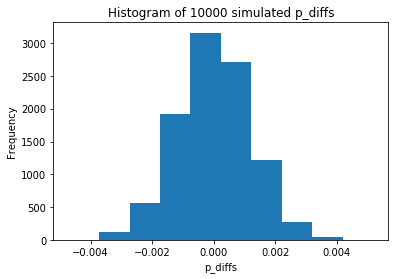

In [27]:
plt.hist(p_diffs)
plt.ylabel('Frequency')
plt.xlabel('p_diffs')
plt.title('Histogram of 10000 simulated p_diffs');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
treatment_conversion = df[df['group'] == 'treatment']['converted'].mean()
control_conversion = df[df['group'] == 'control']['converted'].mean()
dataset_diff =  treatment_conversion - control_conversion 
dataset_diff 

-0.0014795997940775518

In [29]:
#convert to numpy array
p_diffs = np.array(p_diffs)
p_diffs

array([-0.00096541, -0.00014646,  0.00119561, ..., -0.00074561,
       -0.00167493, -0.00055256])

In [30]:
# proportion of p_diffs greater than the actual difference observed in ab_data.csv is computed as:
(dataset_diff < p_diffs).mean()

0.8964

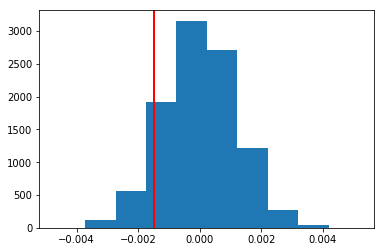

In [31]:
plt.hist(p_diffs);
plt.axvline(dataset_diff,c='r',linewidth = 2);

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**<br>
The value above represents the p-value of observing the statistic given the Null is true. As the p-value is large enough, we would fail to reject the Null hypothesis and keep the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [34]:
from scipy.stats import norm

# Shows the significance of the z_score
print(norm.cdf(z_score))

0.9050583127590245


In [35]:
# for our single-sides test, assumed at 95% confidence level, we calculate: 
print(norm.ppf(1-(0.05)))

# Gives us the critical value at 95% confidence. 
# We take the 95% values as specified in Part 2.1

1.6448536269514722


**Answer**<br>
1. We note that the z-score of 1.31092419842 is less than the critical value of 1.64485362695. So, we can accept the null hypothesis.<br>
2. Coming to the conversion rates of the old and new pages, we find that old pages are only slightly better than new pages.<br>
3. Hence, yes they do agree to the findings of parts j and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:**
Since this is a Yes/No kind of variable, the appropriate approach is Logistic Regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2['intercept']=1

df2[['control', 'treatment']] = pd.get_dummies(df2['group'])

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [37]:
logit = sm.Logit(df2['converted'],df2[['intercept','treatment']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 05 Jul 2019   Pseudo R-squ.:               8.077e-06
Time:                        17:49:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

p-value = -1.311<br>

Our Hypothesis:<br>
**H1  :  p<sub>new</sub>  -  p<sub>old</sub>  != 0**

There difference is that in part 2 we used a one-sided test, but in logistic regression we do a two sided test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**<br>
1. We need to include other factors to the regression model since they too might affect the conversions. They may add more meaning to the test results and be more accurate. For instance student segments [new v/s returning candidates] might create change aversion or even, the opposite as a predisposition to conversion.

2. One of the disadvantages of adding additional terms into the regression model is Simpson's paradox where the combined impact of different variables disappears or reverses when these variables are combined, but appears where these variables are tested individually.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [41]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 834778 to 934996
Data columns (total 8 columns):
country         290584 non-null object
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
control         290584 non-null uint8
treatment       290584 non-null uint8
dtypes: int64(2), object(4), uint8(2)
memory usage: 16.1+ MB


In [42]:
### Create the necessary dummy variables
df_new[['CA', 'US']] = pd.get_dummies(df_new['country'])[['CA','US']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,CA,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
### Fit Your Linear Model And Obtain the Results
df['intercept'] = 1
log_mod = sm.Logit(df_new['converted'], df_new[['CA', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.447174
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 05 Jul 2019   Pseudo R-squ.:                 -0.2214
Time:                        17:49:29   Log-Likelihood:            -1.2994e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA            -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US            -1.9967      0.007   -292.314      0.000      -2.010      -1.983
==============================================================================
"""

From the above results, we can clearly note that there was no significant difference in conversion caused due to the added dummies.
As in this logistic regression model too, we find that the values do not show a substantial difference in teh conversion rates for control group and treatment group.
This shows that we can accept the Null Hypothesis and keep the old page as it is.

<a id='conclusions'></a>
## Conclusions

1. The liking for the old page was found to be better than the new page(though by a very small amount). This could be concluded by the various models we constructed.
2. We accept the Null Hypothesis and reject the Alternate Hypothesis.
3. We may have missed on the accurace as we have used only the data that was available with us. There may be other factors that may affect the coversion rate.

**Resources Used**<br>
1. Udacity Lectures and videos.
2. Stackoverflow for few syntactical errors.

                                                                                      - Gautam Gadiyar